# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

* Add chemical functional groups (R-groups) in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Output structures for free energy calculations

## Overview

This notebook demonstrates the entire `FEgrow` workflow for generating a series of ligands with a common core for a specific binding site, via the addition of a user-defined set of R-groups. 

These *de novo* ligands are then subjected to ADMET analysis. Valid conformers of the added R-groups are enumerated, and optimised in the context of the receptor binding pocket, optionally using hybrid machine learning / molecular mechanics potentials (ML/MM).

An ensemble of low energy conformers is generated for each ligand, and scored using the `gnina` convolutional neural network (CNN). Output structures are saved as `pdb` files ready for use in free energy calculations.

The target for this tutorial is the main protease (Mpro) of SARS-CoV-2, and the core and receptor structures are taken from a [recent study by Jorgensen & co-workers](https://doi.org/10.1021/acscentsci.1c00039).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
!conda install -c conda-forge rdkit prody
!conda install -c conda-forge openff-toolkit-base -y
!conda install -c conda-forge parmed -y

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - prody
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    biopython-1.80             |   py38h0a891b7_0         2.4 MB  conda-forge
    boost-1.78.0               |   py38h4e30db6_4         369 KB  conda-forge
    boost-cpp-1.78.0           |       h75c5d50_1        17.1 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    ca-certificates-2022.12.7  |       ha8

In [2]:
!conda install -c conda-forge openmmforcefields -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openmmforcefields


The following packages will be downloaded:

    package                    |            build
    ---------------------------|--------

In [3]:
!conda install -c conda-forge typing-extensions -y


Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [4]:
!conda install -c conda-forge pdbfixer -y


Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pdbfixer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pdbfixer-1.8.1             |     pyh6c4a22f_0         498 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         498 KB

The following NEW packages will be INSTALLED:

  pdbfixer           conda-forge/noarch::pdbfixer-1.8.1-pyh6c4a22f_0 



                                                                        
Preparing transaction: / done
Verifying transaction: \ done
Executing transaction: / - \ | / - \ | / - \ | / done


In [5]:
!conda install -c conda-forge typing tqdm openbabel -y


Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openbabel
    - tqdm
    - typing


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openbabel-3.1.1            |   py38h3c5e4c7_5         5.6 MB  conda-forge
    typing-3.10.0.0            |     pyhd8ed1ab_0           7 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following NEW packages will be INSTALLED:

  openbabel          conda-forge/linux-64::openbabel-3.1.1-py38h3c5e4c7_5 
  typing             conda-forge/noarch::typing-3.10.0.0-pyhd8ed1ab_0 



typing-3.10.0.0      | 7 KB      | :   

In [6]:
#@title added by Q
!mamba install pytorch torchvision -c pytorch
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pytorch', 'torchvision']

conda-forge/linux-64                                        Using cache


In [7]:
!conda install -c conda-forge torchani 

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [8]:
!conda install -c conda-forge pytorch 

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [9]:
!conda install -c conda-forge openmm pint -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [10]:
!conda install -c conda-forge py3dmol

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - py3dmol


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.8             |       h166bdaf_0         578 KB  conda-forge
    anyio-3.6.2                |     pyhd8ed1ab_0          83 KB  conda-forge
    argon2-cffi-21.3.0         |     pyhd8ed1ab_0          15 KB  conda-forge
    argon2-cffi-bindings-21.2.0|   py38h0a891b7_3          35 KB  conda-forge
    asttokens-2.2.1            |     pyhd8ed1ab_0          27 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    

In [11]:
!conda install -c conda-forge mols2grid

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [12]:
!git clone https://github.com/cole-group/FEgrow.git

Cloning into 'FEgrow'...
remote: Enumerating objects: 4194, done.
remote: Counting objects: 100% (4194/4194), done.
remote: Compressing objects: 100% (1123/1123), done.
remote: Total 4194 (delta 3031), reused 4144 (delta 3006), pack-reused 0
Receiving objects: 100% (4194/4194), 16.00 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (3031/3031), done.


In [13]:
%cd FEgrow

/content/FEgrow


In [14]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/FEgrow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
  Created wheel for fegrow: filename=fegrow-1.1.0-py3-none-any.whl size=4147509 sha256=2f9b0dd7aa71e06147059f85238ec2dbfbd83b7cd9a3d7c35dea94815ceb030d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sghngv47/wheels/04/34/df/9225e000864a482cb37bd5ffcac52379e95eecde1f3d48bab0
Successfully built fegrow
  Attempting uninstall: biopython
    Found existing installation: biop

In [15]:
!python -m ipykernel install --user --name=fegrow

Installed kernelspec fegrow in /root/.local/share/jupyter/kernels/fegrow


In [ ]:
#!python setup.cfg

In [16]:
import copy

import prody
from rdkit import Chem

import fegrow
from fegrow import RGroups

MolGridWidget()

# Prepare the ligand template

The provided core structure `lig.pdb` has been extracted from a crystal structure of Mpro in complex with compound **4** from the Jorgensen study (PDB: 7L10), and a Cl atom has been removed to allow growth into the S3/S4 pocket. The template structure of the ligand is protonated with [Open Babel](http://openbabel.org/wiki/Main_Page):

In [17]:
%cd notebooks

/content/FEgrow/notebooks


In [18]:
!obabel sarscov2/Docked1.pdb -O sarscov2/coreh.sdf -p 7

1 molecule converted


Load the protonated ligand into FEgrow:

In [19]:
init_mol = Chem.SDMolSupplier('sarscov2/coreh.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
template_mol = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

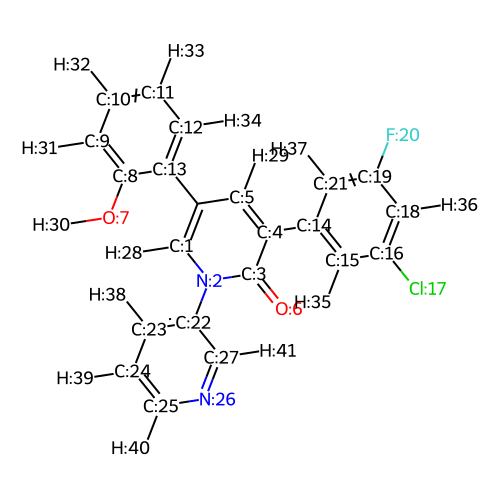

In [20]:
template_mol.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select an index for the growth vector. Note that it is currently only possible to grow from hydrogen atom positions. In this case, we are selecting the hydrogen atom labelled H:40 to enable growth into the S3/S4 pocket of Mpro.

In [21]:
attachment_index = [32]

R-groups can be selected interactively or programmaticaly.

We have provided a set of common R-groups (see `fegrow/data/rgroups/library`), which can be browsed and selected interactively below.

Molecules from the library can alternatively be selected by name, as demonstrated below.

Finally, user-defined R-groups may be provided as `.mol` files. *In this case, the hydrogen atom selected for attachment should be replaced by the element symbol R.* See the directory `manual_rgroups` for examples.

In [22]:
# interactive selection
RGroups

In [23]:
# retrieve the interactively selected groups
interactive_rgroups = RGroups.get_selected()

# you can also directly access the built-in dataframe programmatically
groups = RGroups.dataframe
R_group_ethanol = groups.loc[groups['Name']=='*CC(F)(F)F']['Mol'].values[0]
R_group_cyclopropane = groups.loc[groups['Name'] == '*C1CC1' ]['Mol'].values[0]

# add your own R-groups files
R_group_propanol = Chem.MolFromMolFile('manual_rgroups/propan-1-ol-r.mol', removeHs=False)
# make a list of R-group molecule
selected_rgroups = [R_group_propanol, R_group_ethanol, R_group_cyclopropane] + interactive_rgroups
selected_rgroups

# Build a congeneric series

Now that the R-groups have been selected, we merge them with the ligand core:

In [24]:
rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fb42577a400> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fb4257079a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fb425707f40> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fb426208580>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fb4257079a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fb42577a400>


In [25]:
rmols

,Smiles,Molecule
ID,,
0,[H]Oc1c([H])c(OC([H])([H])C([H])([H])C([H])([H...,<rdkit.Chem.rdchem.Mol object at 0x7fb4256dbc40>
1,[H]Oc1c([H])c(C([H])([H])C(F)(F)F)c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fb4256e40a0>
2,[H]Oc1c([H])c(C2([H])C([H])([H])C2([H])[H])c([...,<rdkit.Chem.rdchem.Mol object at 0x7fb4256e4700>


The R-group library can also be viewed as a 2D grid, or individual molecules can be selected for 3D view (note that the conformation of the R-group has not yet been optimised):

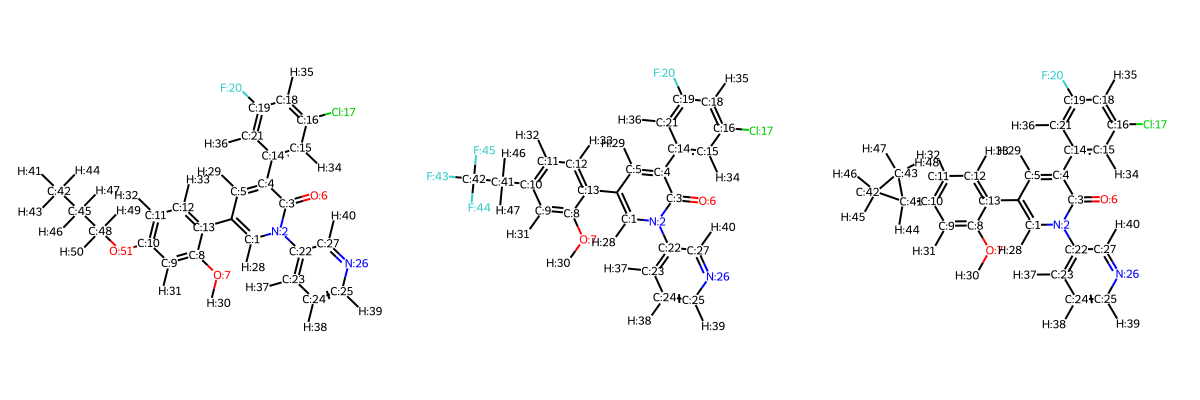

In [26]:
rmols.rep2D()

In [27]:
rmols[1].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility.

In [28]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility,Smiles,Molecule
ID,,,,,,,,,,,
0,450.897,5,1,5.853,True,False,False,True,7.659009,[H]Oc1c([H])c(OC([H])([H])C([H])([H])C([H])([H...,<rdkit.Chem.rdchem.Mol object at 0x7fb42578aac0>
1,474.841,4,1,6.169,True,False,False,True,7.071549,[H]Oc1c([H])c(C([H])([H])C(F)(F)F)c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fb4256e42e0>
2,432.882,4,1,5.942,True,False,False,True,7.508981,[H]Oc1c([H])c(C2([H])C([H])([H])C2([H])[H])c([...,<rdkit.Chem.rdchem.Mol object at 0x7fb42569a6a0>


For each ligand, a specified number of conformers (`num_conf`) is generated by using the RDKit [ETKDG algorithm](https://doi.org/10.1021/acs.jcim.5b00654). Conformers that are too similar to an existing structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that are allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [29]:
rmols.generate_conformers(num_conf=50, 
                          minimum_conf_rms=0.5, 
                          # flexible=[3, 18, 20])
                        )

RMol index 0
Removed 19 duplicated conformations, leaving 32 in total. 
RMol index 1
Removed 41 duplicated conformations, leaving 10 in total. 
RMol index 2
Removed 38 duplicated conformations, leaving 13 in total. 


### Prepare the protein

In [33]:
!pwd

/content/FEgrow/notebooks


The protein-ligand complex structure is downloaded, and [PDBFixer](https://github.com/openmm/pdbfixer) is used to protonate the protein, and perform other simple repair:

In [34]:
# get the protein-ligand complex structure
#!wget -nc https://files.rcsb.org/download/7L10.pdb

# load the complex with the ligand
sys = prody.parsePDB('prot_lig_prod_1.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

@> 45760 atoms and 1 coordinate set(s) were parsed in 0.83s.
@> 4638 atoms and 1 coordinate set(s) were parsed in 0.05s.


View enumerated conformers in complex with protein:

In [35]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (any atom-atom distance less than 1 Angstrom), are removed.

In [36]:
rmols.remove_clashing_confs(rec_final)

RMol index 0
RMol index 1
RMol index 2


In [37]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the [ANI2x](https://doi.org/10.1021/acs.jctc.0c00121) neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). Note that the Open Force Field [Parsley](https://doi.org/10.1021/acs.jctc.1c00571) force field is used for intermolecular interactions with the receptor.

`sigma_scale_factor`: is used to scale the Lennard-Jones radii of the atoms.

`relative_permittivity`: is used to scale the electrostatic interactions with the protein.

`water_model`: can be used to set the force field for any water molecules present in the binding site.

In [ ]:
#!conda install -c conda-forge openff-toolkit

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [38]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="gaff", 
    use_ani=False,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None
)

RMol index 0
Using force field


Optimising conformer: 100%|█████████████████████| 32/32 [00:20<00:00,  1.58it/s]


RMol index 1
Using force field


Optimising conformer: 100%|█████████████████████| 10/10 [00:05<00:00,  1.77it/s]


RMol index 2
Using force field


Optimising conformer: 100%|█████████████████████| 13/13 [00:07<00:00,  1.69it/s]


Any of the rmols that have no available conformers (due to unresolvable steric clashes with the protein) can be discarded using the `.discard_missing()` function. This function also returns a list of the indices that were removed, which can be helpful when carrying out data analysis.

In [39]:
missing_ids = rmols.discard_missing()

Optionally, display the final optimised conformers. Note that, unlike classical force fields, ANI allows bond breaking. You may occasionally see ligands with distorted structures and very long bonds, but in our experience these are rarely amongst the low energy structures and can be ignored.

In [40]:
rmols[1].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure:

In [41]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2


Save all of the lowest energy conformers to files and print the sorted energies in kcal/mol (shifted so that the lowest energy conformer is zero).

In [42]:
[rmol.to_file(f"best_conformers{i}.pdb") for i, rmol in enumerate(rmols)]

[None, None, None]

In [43]:
print(final_energies)

                Energy
ID Conformer          
0  0          0.000000
   1          0.000176
   2          0.030558
   3          0.030702
   4          0.030703
   5          0.513613
   6          0.702142
   7          0.702432
   8          0.718956
   9          0.732975
   10         1.263932
   11         1.263948
   12         1.326743
   13         1.326797
   14         1.327073
   15         1.363571
   16         1.363588
   17         1.365257
   18         1.413662
   19         1.413906
   20         1.414986
   21         1.788375
   22         1.818073
   23         1.983037
   24         1.983091
   25         1.983347
   26         2.024522
   27         2.024561
   28         3.244494
   29         3.300731
1  0          0.000000
   1          0.000222
   2          0.000284
   3          0.000320
   4          0.000323
   5          0.000383
   6          0.088377
   7          0.088476
   8          0.088495
   9          0.303827
2  0          0.000000
   1       

The conformers are scored using the [Gnina](https://github.com/gnina/gnina) molecular docking program and convolutional neural network scoring function. *[Note that this step is not supported on macOS].* If unavailable, the Gnina executable is downloaded during the first time it is used. The CNNscores may also be converted to predicted IC50 (nM) (see column "CNNaffinity->IC50s").

In [44]:
affinities = rmols.gnina(receptor_file="rec_final.pdb") 
affinities

RMol index 0
Gnina not found or set. Download gnina (~500MB) into /content/FEgrow/notebooks
RMol index 1
RMol index 2


CNNaffinity  CNNaffinity->IC50s
ID Conformer                                 
0  0              5.41691         3829.040853
   1              5.41690         3829.129021
   2              5.43147         3702.797825
   3              5.43148         3702.712566
   4              5.43148         3702.712566
   5              5.40589         3927.443988
   6              5.45473         3509.700035
   7              5.45475         3509.538411
   8              5.40020         3979.238776
   9              5.46865         3398.990885
   10             5.47073         3382.750758
   11             5.47073         3382.750758
   12             5.44536         3586.245365
   13             5.44536         3586.245365
   14             5.44535         3586.327943
   15             5.40877         3901.485525
   16             5.40877         3901.485525
   17             5.40868         3902.294124
   18             5.47307         3364.573345
   19             5.47311         3364.263471
   20             5.47059         3383.841404
   21             5.46827         3401.966244
   22             5.46763         3406.983262
   23             5.49428         3204.202833
   24             5.49428         3204.202833
   25             5.49427         3204.276613
   26             5.41967         3804.783942
   27             5.41966         3804.871551
   28             5.47553         3345.569067
   29             5.45885         3476.562169
1  0              5.53637         2908.238370
   1              5.53639         2908.104444
   2              5.53639         2908.104444
   3              5.53642         2907.903566
   4              5.53642         2907.903566
   5              5.53644         2907.769655
   6              5.59892         2518.140744
   7              5.59894         2518.024782
   8              5.59902         2517.560987
   9              5.64417         2268.976511
2  0              5.49826         3174.972734
   1              5.49826         3174.972734
   2              5.49825         3175.045841
   3              5.58366         2608.194652
   4              5.55404         2792.286650
   5              5.55404         2792.286650
   6              5.55404         2792.286650
   7              5.55403         2792.350946
   8              5.50016         3161.112849
   9              5.50017         3161.040062
   10             5.50016         3161.112849
   11             5.55067         2814.038274
   12             5.55068         2813.973479

Predicted binding affinities may be further refined using the structures output by `FEgrow`, using your favourite free energy calculation engine. See our paper for an example using [SOMD](https://github.com/michellab/Sire) to calculate the relative binding free energies of 13 Mpro inhibitors.